# Master M3IR
# TP 1, exercice 3: Classification simple d'images

Cet exercice est à réaliser avec l'environnement Jupyter d'Anaconda https://www.anaconda.com/

**Objectif:** Analyse en composantes principales, Classification par régression logistique  

In [1]:
# Initialisations
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
import sklearn

In [2]:
from sklearn.decomposition import PCA

## Données

On va utiliser des images en niveau de gris de visages, 

> Grayscale faces 8 bit `[0-255]`, a few images of several different people.
> 400 total images, 64x64 size.
> From the Olivetti database at ATT.

Fichier à télécharger: [olivettifaces.mat](http://www-l2ti.univ-paris13.fr/~viennet/ens/AFDV/data/olivettifaces.mat) (4,1Mo).

Le format est un peu spécial, il s'agit d'une matrice matlab. On va le lire comme suit:

In [3]:
D = scipy.io.loadmat('./olivettifaces.mat') # modifier chemin si nécessaire
# La matrice est transposée (lignes/colonnes):
X = D['faces'].transpose()
print(X.shape)

(400, 4096)


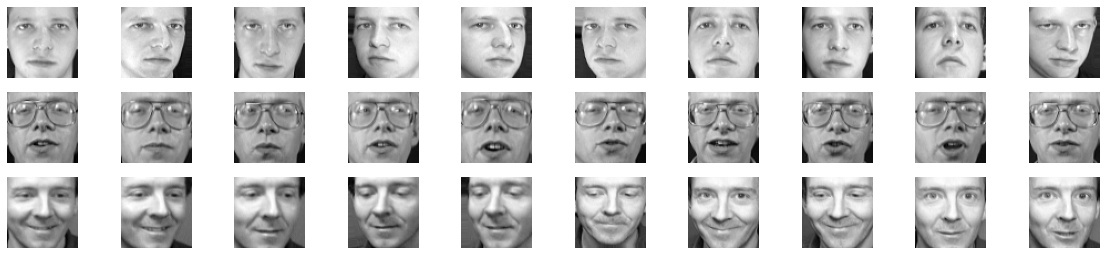

In [4]:
# Affichage de quelques exemples:
plt.figure(figsize=(20,6))
N = 30 # nombre d'exemples à afficher
MaxNbPerLine = 10 

nrows = N // MaxNbPerLine + 1 
ncols = min(N, MaxNbPerLine)
index = 1 # indice dans la figure

for idx, image in enumerate(X[:N]):
    plt.subplot(nrows, ncols, index)
    plt.axis('off')    
    plt.imshow(image.reshape((64,64)).transpose(), cmap=plt.cm.gray)
    index += 1

On voit qu'on a dix images de chaque personne, dans l'ordre. Chaque image est de taille 64x64 = 4096 pixels.


## Image moyenne
Convertir les images en float, calculer et afficher l'image moyenne.

Type of image:  float64
Type of image:  float64
Type of image:  float64
Type of image:  float64


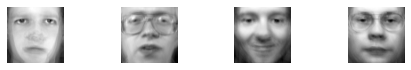

In [75]:
# Réponse

# Affichage de quelques exemples:
plt.figure(figsize=(20,6))
N = 40 # nombre d'exemples à afficher
MaxNbPerLine = 10 

nrows = N // MaxNbPerLine + 1 
ncols = min(N, MaxNbPerLine)
index = 1 # indice dans la figure

## create a list to store list images of a person
list_img_per = []
## a variable to count the images of a person
count = 0

for image in X[:N]:
    list_img_per.append(image)
    count += 1
    if count % MaxNbPerLine == 0:
        array_img_per = np.array(list_img_per, dtype = float)
        print('Type of image: ',array_img_per.dtype)
        array_img_per_mean = np.mean(array_img_per, axis = 0)
        list_img_per = [] 
        plt.subplot(nrows, ncols, index)
        plt.axis('off')
        plt.imshow(array_img_per_mean.reshape((64,64)).transpose(), cmap=plt.cm.gray)
        index += 1

## Analyse en composantes principales
Calculer une ACP pour projeter les images en deux dimensions et afficher les images dans le plan.

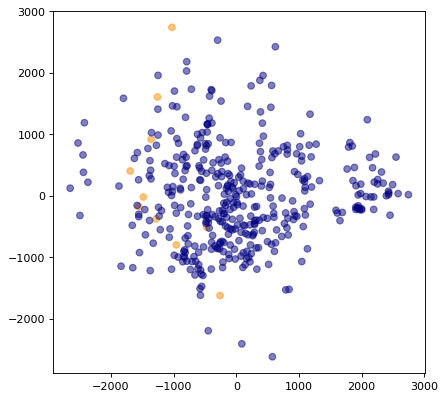

In [77]:
pca = PCA(n_components=2)
feature_pca = pca.fit_transform(X)
color = ['darkorange']*10 + ['navy']*390
plt.figure(figsize=(6, 6), dpi=80)
x = [item[0] for item in feature_pca.tolist()]
y = [item[1] for item in feature_pca.tolist()]
plt.scatter(x, y, color= color, alpha=0.5)
plt.show()

## Classification

Estimer un modèle de classification par régression logistique. Le modèle sera estimé (appris) sur 7 visages par personne, et testé sur les 3 images restantes.

On pourra s'inspirer de l'[exemple de la documentation](https://scikit-learn.org/stable/auto_examples/linear_model/plot_iris_logistic.html)

Quelle est la personne sur laquelle le modèle commet le plus d'erreurs ?

In [69]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from IPython import display
from tqdm import tqdm
from sklearn.metrics import confusion_matrix
import seaborn as sns


def logreg_classifier(dataset, vis_res = False, use_pca = False, ncomp = None):
    """
    pipeline logistic regression classification using sklearn
    need to investigate the number of components for the best performance
    
    params:
        dataset: flatten images of 40 persons
        vis_res: visualize result in validation set
        use_pca: adopt PCA transform
        ncomp: investigate a list number of component
        
    return:
        acc: accuracy
    """
    if use_pca:
        pca = PCA(n_components=ncomp)
        feature = pca.fit_transform(dataset)
    else:
        feature = dataset
    
    n_per = 40
    df_ = pd.DataFrame([])
    df_['data'] = list(feature[:n_per*10])
    per_id = sorted(list(range(n_per))*10)
    df_['label'] = per_id
    
    df_train = pd.DataFrame([])
    df_valid = pd.DataFrame([])

    for per_id in range(40):
        df_per = df_[df_['label']==per_id]
        df_per = df_per.sample(frac = 1).reset_index()
        df_per_train, df_per_valid = df_per[:7], df_per[7:]
        df_train = pd.concat([df_train, df_per_train], axis = 0)
        df_valid = pd.concat([df_valid, df_per_valid], axis = 0)
    
    logreg = LogisticRegression(max_iter=2500)
    logreg.fit(np.array(list(df_train['data'])), df_train['label'])
    
    y_pred = logreg.predict(np.array(list(df_valid['data'])))
    valid_acc = metrics.accuracy_score(df_valid.label, y_pred)
    
    y_hat = logreg.predict(np.array(list(df_train['data'])))
    train_acc = metrics.accuracy_score(df_train.label, y_hat)
    
    df_valid['pred'] = y_pred
    if vis_res:
        display.display(df_valid.head(10))     
        
        cf_matrix = confusion_matrix(df_valid.label, y_pred)
        plt.figure(figsize = (10,10))
        sns.heatmap(cf_matrix, annot=True, cmap='Blues')
        plt.xlabel('Predicted', fontsize=12)
        plt.ylabel('True', fontsize=12)
        
        df_valid_diff = df_valid.iloc[np.where(np.equal(df_valid.label, y_pred)==False)]
        dict_diff = dict(df_valid_diff['label'].value_counts())
        for kv in list(dict_diff.items()):
            print('PersonID: {0} error {1}/3 faces'.format(kv[0], kv[1]))
        
    return train_acc, valid_acc

,data,label,pred
7,"[31, 32, 32, 31, 33, 32, 31, 29, 28, 27, 28, 2...",0,0
8,"[59, 53, 60, 59, 55, 53, 53, 53, 50, 50, 51, 5...",0,0
9,"[92, 94, 89, 93, 108, 121, 125, 125, 125, 128,...",0,0
17,"[142, 152, 148, 148, 151, 167, 169, 155, 137, ...",1,1
18,"[165, 170, 175, 179, 179, 176, 175, 173, 174, ...",1,1
19,"[137, 143, 147, 149, 150, 154, 163, 162, 147, ...",1,1
27,"[42, 37, 35, 33, 35, 37, 41, 45, 47, 48, 51, 4...",2,2
28,"[126, 118, 117, 114, 124, 127, 124, 123, 127, ...",2,2
29,"[131, 127, 126, 132, 136, 136, 136, 134, 136, ...",2,2
37,"[25, 42, 47, 42, 39, 40, 41, 42, 38, 39, 38, 3...",3,3


PersonID: 9 error 2/3 faces
PersonID: 4 error 1/3 faces
PersonID: 7 error 1/3 faces
PersonID: 12 error 1/3 faces
Training accuracy classification: 100.000%
Validation accuracy classification: 95.833%


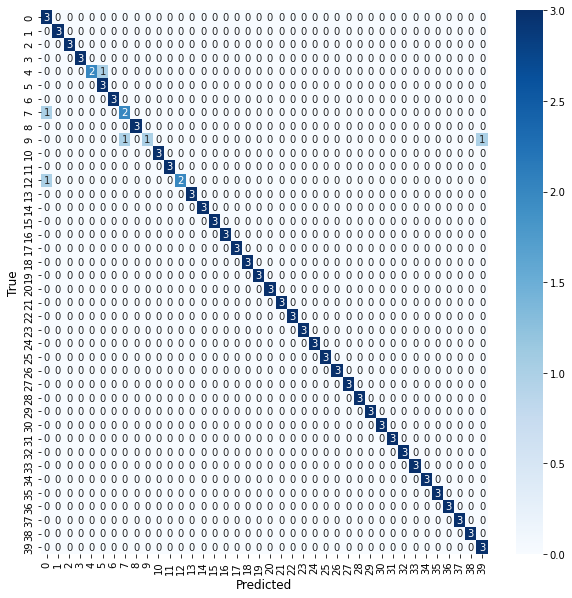

In [70]:
train_acc, valid_acc = logreg_classifier(dataset = X, vis_res = True)
print(f'Training accuracy classification: {100*train_acc:.3f}%')
print(f'Validation accuracy classification: {100*valid_acc:.3f}%')

In [71]:
list_ncomp = list(range(2,100,2))
valid_accs = []
for ncomp in tqdm(list_ncomp):
    train_acc, valid_acc = logreg_classifier(dataset = X, vis_res = False, use_pca = True, ncomp = ncomp)
    valid_accs.append(valid_acc)

  0%|                                                                       | 0/49 [00:00<?, ?it/s]C:\Users\Admin\anaconda3\envs\vision\lib\site-packages\sklearn\linear_model\_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
  2%|█▎                                                             | 1/49 [00:07<06:09,  7.70s/it]C:\Users\Admin\anaconda3\envs\vision\lib\site-packages\sklearn\linear_model\_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data

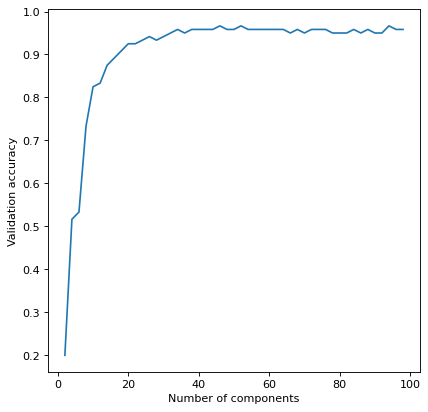

In [74]:
plt.figure(figsize=(6, 6), dpi=80)
plt.plot(list_ncomp,valid_accs)
plt.xlabel('Number of components')
plt.ylabel('Validation accuracy')
plt.show()

,data,label,pred
7,"[-1360.8233408709898, 919.2216838008042, 364.6...",0,0
8,"[-1694.9413285425799, 404.83870976141105, -541...",0,0
9,"[-474.6929660655174, -506.8315074820515, 1368....",0,0
17,"[75.00518066539449, -590.5447910471539, -584.1...",1,1
18,"[140.23694370962485, -1119.67071531456, -935.8...",1,1
19,"[-63.61263337001011, -380.3460021066745, -556....",1,1
27,"[-433.63011655690735, 1263.572745167422, 700.0...",2,2
28,"[-727.939106414202, -129.04673521207025, 717.6...",2,9
29,"[-620.249122726102, -331.3252869397024, 698.52...",2,2
37,"[-133.1460030293831, 361.6461552726709, -180.1...",3,3


PersonID: 9 error 2/3 faces
PersonID: 2 error 1/3 faces
PersonID: 7 error 1/3 faces
PersonID: 11 error 1/3 faces
The best number of components is: 40
Training accuracy classification: 100.000%
Validation accuracy classification: 95.833%


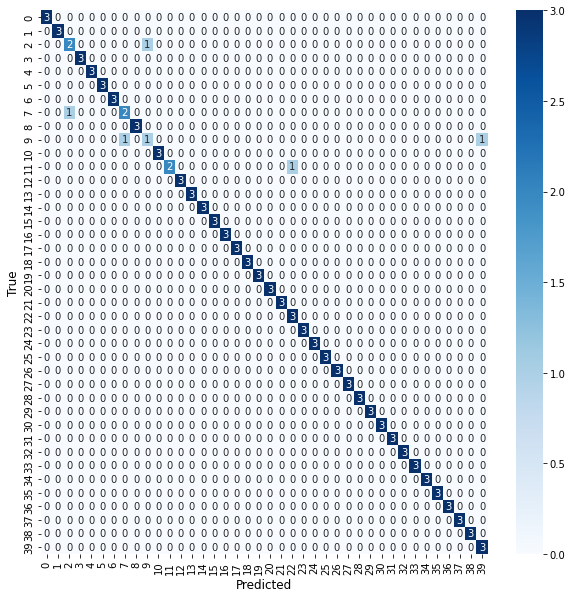

In [73]:
best_ncomp = list_ncomp[valid_accs.index(max(valid_accs))]
train_acc, valid_acc = logreg_classifier(dataset = X, vis_res = True, use_pca = True, ncomp = best_ncomp)
print(f'The best number of components is: {best_ncomp}')
print(f'Training accuracy classification: {100*train_acc:.3f}%')
print(f'Validation accuracy classification: {100*valid_acc:.3f}%')